## Unsupervised clustering
In the next example, I was trying to recreate the results of
https://arxiv.org/abs/1611.02648
on the MNIST data set.

When I try to implement almost the exact architecture as in the paper,
the model fails to utilize the categorical parameter. Instead it either picks a single category
always, or in another variation it gives all the categories equal weight always.
In either case the result is either a single cluster, of K meaningless clusters.


So next I tried a trick I developped.
Given a fixed $w.z$, We actually expect $Q(y|w,z)$, the categorical encoder, to be 
almost entirely concentrated on a single category, essentially constant, on the "real" category of the sample. However trying to make this distribution as close as possible to uniform over all categories doesn't make sense in this context (they sort of talk about it in the article and in another data set also had to twick with this term.

So my solution is to add the regulatory term $- max(Q(y|w,z)$ (to minimize), in other words, we try to maximize the lieklihood of a leading category.
But if we just leave it like that the network again just fixes one category which it always picks.

So I add a second term which forces $Q(y|w,z)$ given many samples, to be like the uniform discrete distribution, by maximizing $K * max(mean(Q, i))$ where the mean goes for each category
$K$ is the number of categories and my experiments shows it is necessary to scale this term.

Anyway my results still aren't perfect, at least when the number of categories is exactly $10$.
With $20$ categories it seems that I get rather homogenous clusters.

Some more explanations:

What I am doing, mathematically is the following. Given a sample $x$, it has a fixed but unknown 
label $l$. Given many samples, $P(l)$ has categorical distribution so we can assume a prior
distribution $P(l)=1.k$ or maybe take it a step further and say that $P(l) = P(l|d)$
where $d$ is a  Dirichlet parameter.

Now we have the original label variable $y$, what's the point of two variables for the same entity?

We can do this trick: $P(y=x|l=y) = \delta_{x,y}$. It is a distribution over the $K$ categories that is completely concentrated on one yet unknown label. And the inference model $Q(y|z)$ tries to minimize the KL divergence with $P(y|l)$, rather than with $P(y) = P(l) = 1/K$, which is a completely different thing.

Then $Q(l|y)$ tries to minimize KLD with $P(l)$, so basically I claim that we need to add this extra regulatory condition and it fits the theoretical inference model (I will write more
about it in a separate document).



In [6]:
#import gdown
import matplotlib.pyplot as plt
import numpy as np
#import os
import pandas as pd
import pyro
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
#import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from sklearn import mixture
from torch.nn import functional as F

import gmmvae02 as M
import gmmvae03 as M2

print(torch.cuda.is_available())


True
True


In [7]:
transform = transforms.Compose([
    #transforms.Resize((32,32)),
    transforms.ToTensor(),
    #normalize,
    ])
test_loader = torch.utils.data.DataLoader(
   dataset=datasets.MNIST(
       root='data/',
       train=False,
       download=True,
       transform=transform,
       ),
   batch_size=128,
   shuffle=True,
)
train_loader = torch.utils.data.DataLoader(
   dataset=datasets.MNIST(
       root='data/',
       train=True,
       download=True,
       transform=transform,
       ),
   batch_size=128,
   shuffle=True,
)

x, y = test_loader.__iter__().__next__()

test_data = test_loader.dataset.data.float()/255
test_labels = test_loader.dataset.targets
train_data = train_loader.dataset.data.float()/255
train_labels = train_loader.dataset.targets


In [8]:
test_data = test_loader.dataset.data.float()/255
test_labels = test_loader.dataset.targets
train_data = train_loader.dataset.data.float()/255
train_labels = train_loader.dataset.targets


In [10]:
## Dilo GMM tests
# with 20 clusters
model = M.VAE_Dilo(nclasses=20)
model.apply(init_weights)
model.fit(train_loader, num_epochs=12)

rec_loss: 184.82492065429688
z_loss: 13.105541229248047
w_loss: 4.343296051025391
y_loss: 0.28915056586265564
total_loss: 202.5629119873047
rec_loss: 35.136695861816406
z_loss: 7.922885894775391
w_loss: 0.2893609404563904
y_loss: -0.32972657680511475
total_loss: 43.01921463012695
rec_loss: 31.394939422607422
z_loss: 8.610698699951172
w_loss: 0.3229292929172516
y_loss: -0.37727439403533936
total_loss: 39.9512939453125
rec_loss: 30.905380249023438
z_loss: 10.054410934448242
w_loss: 0.2893482446670532
y_loss: -0.23296886682510376
total_loss: 41.01617431640625
rec_loss: 29.75174903869629
z_loss: 10.123895645141602
w_loss: 0.3340076804161072
y_loss: -0.36920708417892456
total_loss: 39.84044647216797
rec_loss: 28.877300262451172
z_loss: 10.506243705749512
w_loss: 0.3174719512462616
y_loss: 0.22405731678009033
total_loss: 39.925071716308594
rec_loss: 26.262157440185547
z_loss: 10.902057647705078
w_loss: 0.33075636625289917
y_loss: -0.40867578983306885
total_loss: 37.08629608154297
rec_loss: 2

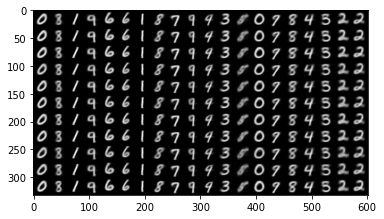

In [11]:
ws = distributions.Normal(0,1).sample((11,150))
mus_logvars_z_w = model.P_z_wy(ws).reshape(-1, model.nclasses, 2*model.nz)
mus_z_w = mus_logvars_z_w[:,:,:model.nz]
logvars_z_w = mus_logvars_z_w[:,:,model.nz:]
xs = model.Px_z(mus_z_w)
xs = xs.reshape(-1,10,1,28,28)
ut.plot_images(xs.reshape(-1,1,28,28), model.nclasses)

To explain what's going on in the aboce image:
we sample (normally distributed) from the $w$ latent space, and using the encoder, it creates 20 components for each sample. We take $11$ samples from $w$ so we get $20 \times 11$ images. And we see that each componnent reproduces the same digit. Some digits like $9$ and $1$ have multiple components. All the digits appear, sort of. We got unlucky in a previous run with the digit $4$ which seems to not be concentrated in any specific component.

There are also issues of numerical stability (sometimes during training we get nan error) this is likely fixable by using weight decay in the training.

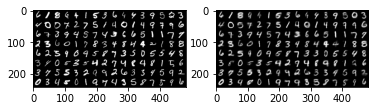

In [12]:
output = model(x)
rec = output["rec"].reshape(-1,1,28,28)
ut.plot_2images(x, rec)

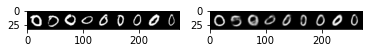

In [13]:
ut.plot_2images(x[y==0], rec[y==0])

In [32]:
output = model(test_data[:500])
y = test_labels[:500]
print(output["q_y"][y==0].argmax(-1))
print(output["q_y"][y==1].argmax(-1))
print(output["q_y"][y==2].argmax(-1))

tensor([ 0, 13, 13,  0, 13, 13, 13, 13, 13, 13, 13, 13,  0, 13,  0,  0, 13, 13,
        13,  0, 13, 13, 13,  0, 13, 13,  0, 13,  0,  0,  0, 13, 13, 13, 13, 13,
         0,  7, 13, 13,  5, 15])
tensor([ 2,  2,  6,  6,  6,  6,  6,  6,  1,  2,  6,  2,  6,  1,  2,  6,  2,  6,
         6,  6,  6,  6,  6,  9,  1,  2,  6,  6,  2,  6,  2,  2,  2,  6,  6,  6,
         6,  6,  2,  6,  2,  6,  6,  6,  6,  6,  6,  6,  6,  6, 12,  6,  6,  6,
         6,  2,  6,  6,  6,  6,  6,  6,  2,  6,  6,  2,  2])
tensor([18, 19, 18,  2, 18, 19, 18, 19, 19, 16, 19,  3, 11, 18, 11, 18, 19, 18,
         0, 18, 18, 18, 18, 18, 18, 19, 19, 18, 18, 11, 18,  4, 18, 18, 13,  1,
        18, 18,  1, 18, 18, 18, 18, 18, 19, 19, 19, 11, 18,  7, 18,  1,  1, 19,
         7])


In [33]:
print(output["q_y"][y==3].argmax(-1))
print(output["q_y"][y==4].argmax(-1))
print(output["q_y"][y==5].argmax(-1))

tensor([17, 11, 17,  9, 17, 19,  1, 17, 17, 11, 11,  1,  1, 13, 17,  3, 11, 11,
         2,  1, 11,  1, 17, 17,  1, 11, 17,  1, 11, 15, 17,  3, 11,  3, 17, 17,
        11,  1, 17, 17, 11, 11, 17, 14, 17])
tensor([ 3, 16,  3,  3, 16, 12, 16,  9,  3,  3,  1, 16, 16, 16, 16, 16, 10, 16,
        16, 10, 16,  9,  9,  3, 16, 16,  3,  3, 16,  9,  9,  5, 16,  9, 16,  3,
         3,  2, 10, 10, 10,  3,  9,  3,  3, 16,  3, 14, 16,  9,  5, 12,  3, 16,
        10])
tensor([ 9, 17,  7, 11,  9, 17, 12, 15, 15, 15, 15, 17,  7, 15,  7, 15, 17, 12,
         7, 17, 17, 10, 14,  1, 17, 17,  7,  7, 17, 12, 17, 15, 18, 15, 17, 17,
        15, 15, 17, 15, 17, 17, 13, 17, 12,  9, 15, 15, 12, 15])


In [34]:
print(output["q_y"][y==6].argmax(-1))
print(output["q_y"][y==7].argmax(-1))

tensor([ 4,  4,  4,  5,  4,  4,  4,  4,  5,  4,  4,  4,  4,  5,  4,  5,  4,  5,
        16,  5,  4,  7,  4,  5,  7,  4, 16,  4,  4,  4,  4,  4,  0,  4,  5, 12,
         4, 17,  4,  4,  4,  4,  5])
tensor([ 8,  8,  3, 14,  8,  8,  3, 14,  8,  9, 14,  9,  9,  8,  8, 10,  8,  9,
         8,  8,  9, 14, 12,  8,  9, 14,  8,  8,  9,  8,  9,  9,  8,  9,  9, 10,
        14,  8,  3,  9,  8,  9, 14,  8,  9,  8, 14,  3,  8])


In [35]:
print(output["q_y"][y==8].argmax(-1))
print(output["q_y"][y==9].argmax(-1))

tensor([19, 15,  7, 15, 15,  1, 17,  1,  1, 11, 15, 17, 15,  7,  1,  7, 13, 17,
        15,  1, 11, 17,  1,  7, 17, 15, 15,  1,  1, 15, 17, 14, 15, 15, 15,  7,
        15, 15, 15, 17])
tensor([ 3, 14,  9, 16, 14, 16,  9, 14, 14, 12,  3,  3,  9,  3,  9, 10,  3,  3,
        17, 16,  3,  9,  3,  3,  9,  9,  3,  9,  1,  9,  3, 10,  3,  3, 16,  2,
         3,  3,  9,  9,  8,  9,  8,  9, 10,  3,  7,  3,  8, 17,  3,  9,  8,  3])


torch.Size([1, 20, 1, 28, 28])

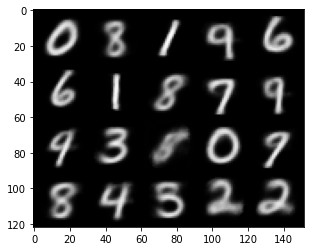

In [45]:
w = torch.zeros(1,model.nw)
mus_logvars_z_w = model.P_z_wy(w).reshape(-1, model.nclasses, 2*model.nz)
mus_z_w = mus_logvars_z_w[:,:,:model.nz]
logvars_z_w = mus_logvars_z_w[:,:,model.nz:]
xs = model.Px_z(mus_z_w)
xs = xs.reshape(-1,model.nclasses,1,28,28)
ut.plot_images(xs.reshape(-1,1,28,28), 5)
xs.shape

The above image shows the mapping of the "cluster heads", these are the images that result
when we feed $w=0$ to the encoder.

My intent to try in the future: identify images of the test set which are sufficiently close to the cluster heads, assign them a the label of the cluster head. Then do semi supervised training 
on the testing set.

We would need to make sure that in the partially labeled set we don't assign false labels... I think it is doable.

### Another model
I am trying another model:
We think or $Q(y|x)$ as cluster centers.
Map (insert number) of cluster centers into the latent space $z$.
Map the $x$ inot the latent space.
Minimize the distance between $Q(z|x)$ and the nearsest cluster head, in addition to all the other regularizations....


In [35]:

model = M2.AE2(nz=90, nclasses=18)
model.apply(init_weights)
model.fit(train_loader)

loss_cat: -2.3279008865356445
loss_l: 1.1609632968902588
loss_cluster: 85.18063354492188
loss_rec: 188.1484375
loss_z: 22.14398193359375
total_loss: 294.3061218261719

loss_cat: -9.38464641571045
loss_l: 0.4330136775970459
loss_cluster: 4.037696838378906
loss_rec: 36.46934509277344
loss_z: 1.3927936553955078
total_loss: 32.948204040527344

loss_cat: -9.503586769104004
loss_l: 0.8467474579811096
loss_cluster: 4.570034980773926
loss_rec: 33.40653991699219
loss_z: 1.438309669494629
total_loss: 30.758045196533203

loss_cat: -9.436115264892578
loss_l: 0.456258624792099
loss_cluster: 4.1720123291015625
loss_rec: 32.01830291748047
loss_z: 1.0700981616973877
total_loss: 28.28055763244629

loss_cat: -9.52369499206543
loss_l: 0.4904317259788513
loss_cluster: 4.735146999359131
loss_rec: 32.75910186767578
loss_z: 1.1290236711502075
total_loss: 29.590009689331055

loss_cat: -9.526613235473633
loss_l: 0.4097045958042145
loss_cluster: 4.750626564025879
loss_rec: 30.333141326904297
loss_z: 1.128994584

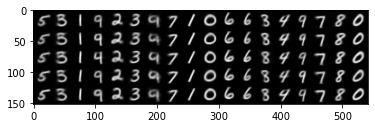

In [39]:
c = torch.eye(model.nclasses)
c = model.clusterhead_embedding(c)
cx = model.Px(c).reshape(-1,1,28,28)

zs = distributions.Normal(loc=c, scale=0.3).sample((5,))
xs = model.Px(zs).reshape(-1,1,28,28)
ut.plot_images(xs, model.nclasses)


In [37]:
c.abs().max(-1)

torch.return_types.max(
values=tensor([1.8057, 2.9511, 2.3888, 1.6831, 2.0046, 2.3716, 2.5105, 1.3967, 2.6064,
        2.4405, 2.1453, 2.3358, 1.9253, 1.9349, 2.0435, 1.5565, 1.8356, 2.5281],
       grad_fn=<MaxBackward0>),
indices=tensor([25, 68, 15, 15,  0,  0,  0, 46, 47, 68, 32, 68, 25, 13, 13,  0, 13, 15]))

In [38]:
output = model(x)
model.LVz(output["h"]).exp().min(-1)

torch.return_types.min(
values=tensor([0.3679, 0.3681, 0.3679, 0.3679, 0.3679, 0.3680, 0.3679, 0.3679, 0.3680,
        0.3680, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3680, 0.3679,
        0.3679, 0.3679, 0.3679, 0.3683, 0.3680, 0.3680, 0.3679, 0.3679, 0.3681,
        0.3679, 0.3680, 0.3679, 0.3679, 0.3679, 0.3682, 0.3679, 0.3679, 0.3679,
        0.3679, 0.3680, 0.3679, 0.3681, 0.3679, 0.3682, 0.3679, 0.3679, 0.3679,
        0.3679, 0.3679, 0.3679, 0.3679, 0.3681, 0.3680, 0.3679, 0.3679, 0.3679,
        0.3679, 0.3679, 0.3680, 0.3680, 0.3684, 0.3680, 0.3680, 0.3679, 0.3679,
        0.3679, 0.3692, 0.3682, 0.3679, 0.3680, 0.3679, 0.3679, 0.3680, 0.3679,
        0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3687, 0.3679, 0.3679, 0.3680,
        0.3682, 0.3680, 0.3680, 0.3679, 0.3679, 0.3679, 0.3686, 0.3680, 0.3686,
        0.3679, 0.3679, 0.3680, 0.3686, 0.3679, 0.3679, 0.3680, 0.3679, 0.3679,
        0.3679, 0.3679, 0.3679, 0.3679, 0.3688, 0.3681, 0.3679, 0.3679, 0.3680,
        0

In [9]:
model = M2.AE2(nz=20, nclasses=10)
model.apply(init_weights)
#model.fit_v2(train_loader)
model.fit(train_loader)


loss_cat: -3.443237781524658
loss_l: 1.0920681953430176
loss_cluster: 19.713022232055664
loss_rec: 184.32656860351562
loss_z: 10.542644500732422
total_loss: 212.2310791015625

loss_cat: -9.591667175292969
loss_l: 0.28953817486763
loss_cluster: 4.118221282958984
loss_rec: 32.99994659423828
loss_z: 3.4704246520996094
total_loss: 31.28646469116211

loss_cat: -9.672456741333008
loss_l: 0.12625516951084137
loss_cluster: 4.062641620635986
loss_rec: 28.969738006591797
loss_z: 3.866619110107422
total_loss: 27.35279655456543

loss_cat: -9.623445510864258
loss_l: 0.12596000730991364
loss_cluster: 3.9693939685821533
loss_rec: 26.930938720703125
loss_z: 4.350064277648926
total_loss: 25.752910614013672

loss_cat: -9.682567596435547
loss_l: 0.1887853443622589
loss_cluster: 4.286775588989258
loss_rec: 25.618053436279297
loss_z: 4.463559627532959
total_loss: 24.87460708618164

loss_cat: -9.800305366516113
loss_l: 0.06369177252054214
loss_cluster: 3.5518131256103516
loss_rec: 25.24793815612793
loss_z: 

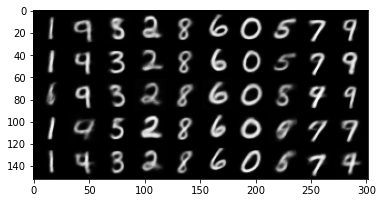

In [13]:
c = torch.eye(model.nclasses)
c = model.clusterhead_embedding(c)
cx = model.Px(c).reshape(-1,1,28,28)
zs = distributions.Normal(loc=c, scale=0.5).sample((5,))
xs = model.Px(zs).reshape(-1,1,28,28)
ut.plot_images(xs, model.nclasses)
